In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx, from_networkx

In [2]:
dataset = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]
print(data)

Dataset: CSL(150):
Number of graphs: 150
Number of features: 0
Number of classes: 10
Data(edge_index=[2, 164], y=[1], num_nodes=41)


### Very basic generation of a graphon

This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.

In [3]:
G = to_networkx(data)

In [4]:
# adjaency_matrix = to_dense_adj(data.edge_index).numpy().squeeze()
adjaency_matrix = nx.to_numpy_array(G)
adjaency_matrix

array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.]])

In [5]:
k = 10
clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjaency_matrix)
labels = clustering.labels_

In [6]:
graphon = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        nodes_i = np.where(labels == i)[0]
        nodes_j = np.where(labels == j)[0]
        # print(nodes_i, nodes_j)
        # raise ValueError('TODO: implement this')
        subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
        graphon[i, j] = nx.density(subgraph)

In [316]:
import torch_geometric
import copy
from typing import List, Tuple
from torch_geometric.data import Batch, Data
from torch_geometric.data.collate import collate
from torch_geometric.data.data import BaseData
from torch_geometric.data.dataset import Dataset, IndexType
from torch_geometric.data.separate import separate
from torch_geometric.io import fs
from torch import from_numpy, mean, svd, lt, diag, t
import torch

class GMixupDataset():
    r"""A wrapper class around a dataset that applies G-Mixup data augmentation to its base dataset.

    Args:
        base_dataset (Dataset): The dataset to apply G-Mixup to.
        TODO
    """

    def __init__(
        self,
        base_dataset: Dataset,
    ) -> None:
        self.base_dataset = base_dataset
        
        self.generate_graphons()
        
    def generate_graphons(self) -> None:
        self.graphs_by_class = [np.empty(0, dtype=int) for _ in range(self.base_dataset.num_classes)]
        
        for i, data in enumerate(self.base_dataset):
            label = data.y.item()
            self.graphs_by_class[label] = np.append(self.graphs_by_class[label], i)
            
        # for i in range(self.base_dataset.num_classes):
        #     print(self.graphs_by_class[i])
            
        self.average_node_count = int(np.mean([data.num_nodes for data in self.base_dataset]))
        # self.average_node_count = 20
        # print(self.average_node_count)
        
        self.graphons = np.zeros((self.base_dataset.num_classes, self.average_node_count, self.average_node_count))
        for i in range(self.base_dataset.num_classes):
            self.graphons[i] = self.generate_graphon(i)
        
        # print(self.graphons)
        return None
    
    def align_graphs(self, graph_adjs:List[np.ndarray]) -> Tuple[List[np.ndarray], List[np.ndarray], int, int] :
        num_nodes = [graph_adj.shape[0] for graph_adj in graph_adjs]
        max_num = max(num_nodes)
        min_num = min(num_nodes)

        aligned_adjs = []
        normalized_node_degrees = []
        for graph_adj in graph_adjs :
            curr_n = graph_adj.shape[0]
            node_degree = 0.5 * np.sum(graph_adj, axis=0) + 0.5 * np.sum(graph_adj, axis=1)
            node_degree /= np.sum(node_degree)
            perm = np.argsort(node_degree)  # ascending
            perm = perm[::-1]  # descending

            sorted_node_degree = node_degree[perm]
            sorted_node_degree = sorted_node_degree.reshape(-1, 1)

            sorted_graph = copy.deepcopy(graph_adj)
            sorted_graph = sorted_graph[perm, :]
            sorted_graph = sorted_graph[:, perm]

            normalized_node_degree = np.zeros((max_num, 1))
            normalized_node_degree[:curr_n, :] = sorted_node_degree
            aligned_adj = np.zeros((max_num, max_num))
            aligned_adj[:curr_n, :curr_n] = sorted_graph
            normalized_node_degrees.append(normalized_node_degree)
            aligned_adjs.append(aligned_adj)
        return aligned_adjs, normalized_node_degrees, max_num, min_num

    def generate_graphon(self, class_idx: int, threshold: float = 1.) -> np.ndarray : # 2.02
        class_adj_mats = [nx.to_numpy_array(to_networkx(self.base_dataset[graph_index])) 
                          for graph_index in self.graphs_by_class[class_idx]]
        aligned_graphs, normalized_node_degrees, max_num, min_num = self.align_graphs(class_adj_mats)
        # aligned_graphs = [nx.to_numpy_array(to_networkx(self.base_dataset[self.graphs_by_class[class_idx][0]]))] # DEBUGGING: use only the first graph
        
        graph_tensor_np = np.array(aligned_graphs)
        graph_tensor = from_numpy(graph_tensor_np).float()
        print(f"DEBUG -- {class_idx} graph_tensor = \n{graph_tensor.shape}\n")
        
        # collapse adj mats into 1 matrix
        if graph_tensor.size(0) > 1 :
            agg_graph_adj = mean(graph_tensor, dim=0)
        else :
            agg_graph_adj = graph_tensor[0, :, :]
        print(f"agg_graph_adj = {agg_graph_adj}\n")
        # svd graphon estimation \cite{Chatterjee}
        U, S, Vh = torch.linalg.svd(agg_graph_adj)
        # print(f"U = {U}\nS = {S}\nV = {V}\n")
        
        num_nodes = agg_graph_adj.size(0)
        num_edges = torch.sum(agg_graph_adj)
        # proportion_edges = torch.sum(torch.triu(agg_graph_adj)) / (num_nodes ** 2)
        proportion_edges = num_edges / (num_nodes ** 2) / 2
        print(f"num_edges = {num_edges}\nnum_nodes = {num_nodes}\nproportion_edges = {proportion_edges}\n")
        
        scaled_thresh = threshold * ((num_nodes * proportion_edges) ** 0.5)
        print(f"scaled_thresh = {scaled_thresh}\n")
        bad_sv_idx = lt(S, scaled_thresh)
        # print(f"sv thresh {scaled_thresh}\nbad sv idx {bad_sv_idx}\n")
        # print(f"S before {S}\n")
        S[bad_sv_idx] = 0 # DEBUGGING: comment out to set the graphon to the adjacency matrix
        graphon = U @ diag(S) @ Vh
        graphon[graphon >= 1] = 1 # clip
        graphon[graphon <= 0] = 0 # clip
        
        print(f"S after {S}\n")
        print(f"{torch.round(graphon, decimals=2)}\n")
        print(f"graphon avg = {torch.mean(graphon)}\n")
        print(f"original avg = {torch.mean(agg_graph_adj)}\n")
        
        return graphon.numpy()
    
    def generate_graphon_spectral(self, class_idx: int) -> np.ndarray:
        r"""This is much simpler than the method described in the paper, only here as a sorta placeholder/demo.
        """
        # print(class_idx)
        # print(self.graphs_by_class[class_idx])
        # print()
        final_graphon = np.zeros((self.average_node_count, self.average_node_count))
        
        for graph_index in self.graphs_by_class[class_idx]:
            data = self.base_dataset[graph_index]
            G = to_networkx(data)
            adjaency_matrix = nx.to_numpy_array(G)
            
            clustering = SpectralClustering(n_clusters=self.average_node_count, affinity='precomputed').fit(adjaency_matrix)
            labels = clustering.labels_

            graphon = np.zeros((self.average_node_count, self.average_node_count))
            for i in range(self.average_node_count):
                for j in range(self.average_node_count):
                    nodes_i = np.where(labels == i)[0]
                    nodes_j = np.where(labels == j)[0]
                    subgraph = G.subgraph(nodes_i.tolist() + nodes_j.tolist())
                    graphon[i, j] = nx.density(subgraph)
                    
            final_graphon += graphon
            # print(graphon)
        
        final_graphon /= len(self.graphs_by_class[class_idx])
        return final_graphon

    # todo: check how IndexType works
    def generate_graphs(self, idx_1: int, idx_2: int, mixing_param: float = 0.5, K: int = 10) -> 'Dataset':
        r"""Takes in a batch of graph label pairs and a mixing parameter λ, and returns the new synthetic graph(s) generated using G-Mixup
        
        Args:
            idx_1 (int): Index of the first graph in the pair
            idx_2 (int): Index of the second graph in the pair
            mixing_param (float): The mixing parameter λ
            K (int): The number of nodes in the output synthetic graph(s)
        """
        graphon1 = self.graphons[idx_1]
        graphon2 = self.graphons[idx_2]
        mixed_graphon = mixing_param * graphon1 + (1 - mixing_param) * graphon2
        
        print(f"DEBUG -- generate_graphs")
        # print(f"graphon1 = \n{graphon1}\n")
        # print(f"graphon1 avg = {np.mean(graphon1)}\n")
        # print(f"graphon2 = \n{graphon2}\n")
        # print(f"graphon2 avg = {np.mean(graphon2)}\n")
        print(f"mixed_graphon = \n{mixed_graphon}, {mixed_graphon.shape}\n")
        print(f"mixed_graphon avg = {np.mean(mixed_graphon)}\n")
        
        u_values = np.random.uniform(0, 1, K)
        u_values.sort()
        u_values_index = (u_values * mixed_graphon.shape[0]).astype(int)
        print(f"u_values = {u_values}\n")
        # u_values_index = np.linspace(0, mixed_graphon.shape[0] - 1, K).astype(int) # DEBUGGING: use this to reconstruct without RNG, should reconstruct nearly the same graph if there is no thresholding
        
        adjacency_matrix = np.zeros((K, K))
        for i in range(K):
            for j in range(K):
                p = mixed_graphon[u_values_index[i], u_values_index[j]]
                # print(f"i = {i}, j = {j}, p = {p}\n")
                if np.random.rand() < p:
                    adjacency_matrix[i, j] = 1
                    # adjacency_matrix[j, i] = 1
        print(adjacency_matrix)
        print("number edges", np.sum(adjacency_matrix))
                
        # graph = nx.from_numpy_array(adjacency_matrix)
        graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
        
        return graph
    
    def __getattr__(self, name: str):
        if name in self.__dict__:
            return getattr(self, name)
        else:
            return getattr(self.base_dataset, name)

In [317]:
gnn_benchmark = GNNBenchmarkDataset(root='tmp/gnn_benchmark', name='CSL')
gmixup_gnn_benchmark = GMixupDataset(gnn_benchmark)

DEBUG -- 0 graph_tensor = 
torch.Size([15, 41, 41])

agg_graph_adj = tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7333],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.7333, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

num_edges = 164.0
num_nodes = 41
proportion_edges = 0.04878048598766327

scaled_thresh = 1.4142135381698608

S after tensor([4.0000, 3.8832, 3.8694, 3.5407, 3.4897, 2.9966, 2.8957, 2.2914, 2.2270,
        2.2252, 2.1632, 2.1514, 2.1420, 2.0466, 2.0313, 1.9117, 1.8730, 1.7050,
        1.6758, 1.5081, 1.4808, 1.4677, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

tensor([[0.6200, 0.0000, 0.0300,  ..., 0.0000

DEBUG -- generate_graphs
mixed_graphon = 
[[0.6166153  0.         0.02602924 ... 0.00405462 0.03635804 0.56535107]
 [0.         0.15832686 1.         ... 0.         0.         0.04999895]
 [0.02602923 1.         0.1562555  ... 0.         0.16596974 0.        ]
 ...
 [0.00405432 0.         0.         ... 0.13824135 0.88903284 0.        ]
 [0.03635796 0.         0.16597004 ... 0.88903344 0.15536819 0.        ]
 [0.56535029 0.049999   0.         ... 0.         0.         0.19230802]], (41, 41)

mixed_graphon avg = 0.11653121529236678

u_values = [0.14689186 0.16701856 0.20496155 0.21358016 0.21677305 0.26657546
 0.28615839 0.28619563 0.34491136 0.36104586 0.3663656  0.38084617
 0.38474157 0.38539824 0.3880598  0.41178194 0.42495167 0.44853953
 0.44953152 0.45261815 0.4790609  0.51075785 0.52527235 0.5274773
 0.56226217 0.60375917 0.64706329 0.66237299 0.68184545 0.7037225
 0.71389735 0.76644325 0.78604803 0.78797353 0.79845519 0.80066361
 0.83640501 0.8463778  0.86564669 0.8762996  0.9045

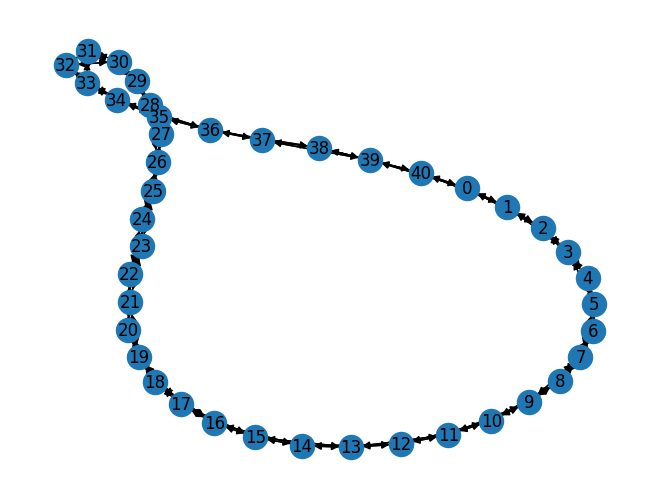

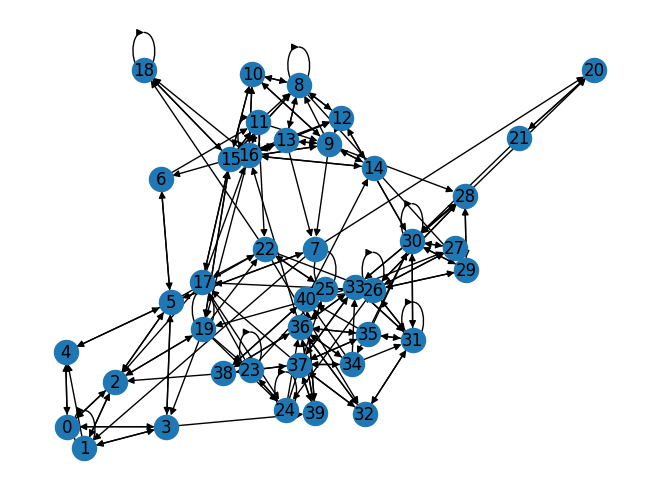

In [320]:
graph_real = to_networkx(gmixup_gnn_benchmark.base_dataset[gmixup_gnn_benchmark.graphs_by_class[0][0]])
graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 0, 0, K=41)
# graph_gen = gmixup_gnn_benchmark.generate_graphs(0, 1, 1)


import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values()))/2)
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values()))/2)
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)

In [61]:
mnist = torch_geometric.datasets.MNISTSuperpixels(root="tmp/mnist")


In [321]:
gmixup_mnist = GMixupDataset(mnist)

DEBUG -- 0 graph_tensor = 
torch.Size([5923, 75, 75])

agg_graph_adj = tensor([[1.6377e-01, 9.5408e-01, 9.4158e-01,  ..., 1.0130e-03, 5.0650e-04,
         0.0000e+00],
        [9.5408e-01, 1.2207e-01, 9.2453e-01,  ..., 1.5195e-03, 8.4417e-04,
         3.3767e-04],
        [9.4158e-01, 9.2453e-01, 9.4209e-02,  ..., 2.8702e-03, 8.4417e-04,
         1.6883e-04],
        ...,
        [1.0130e-03, 1.5195e-03, 2.8702e-03,  ..., 3.3429e-02, 6.6689e-02,
         1.1278e-01],
        [5.0650e-04, 8.4417e-04, 8.4417e-04,  ..., 6.6689e-02, 2.3468e-02,
         5.1157e-02],
        [0.0000e+00, 3.3767e-04, 1.6883e-04,  ..., 1.1278e-01, 5.1157e-02,
         1.3507e-02]])

num_edges = 1332.14404296875
num_nodes = 75
proportion_edges = 0.1184128001332283

scaled_thresh = 2.9800939559936523

S after tensor([20.2495,  5.9012,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  

In [63]:
gmixup_mnist.graphs_by_class[0]

array([    1,    21,    34, ..., 59952, 59972, 59987])

DEBUG -- generate_graphs
mixed_graphon = 
[[1.         0.98110622 0.94925886 ... 0.         0.         0.        ]
 [0.98110777 0.94314444 0.91271085 ... 0.         0.         0.        ]
 [0.94926047 0.91271091 0.88351679 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.13357078 0.12780175 0.11766762]
 [0.         0.         0.         ... 0.12780175 0.12244931 0.11291389]
 [0.         0.         0.         ... 0.11766762 0.11291389 0.10430219]], (75, 75)

mixed_graphon avg = 0.23728682118629935

u_values = [0.01131361 0.03394403 0.03580485 0.03588382 0.04008801 0.05909659
 0.0680962  0.08826771 0.12131569 0.12780568 0.14244634 0.14560676
 0.15000337 0.15115511 0.15368013 0.15698804 0.17509974 0.18743822
 0.21596033 0.25004607 0.25481164 0.2604152  0.26059005 0.26556566
 0.28820605 0.30732211 0.31252297 0.38562222 0.41248002 0.41648658
 0.45601084 0.47406647 0.47421472 0.48028742 0.4846998  0.48719485
 0.50065991 0.52730758 0.527622   0.54813308 0.56

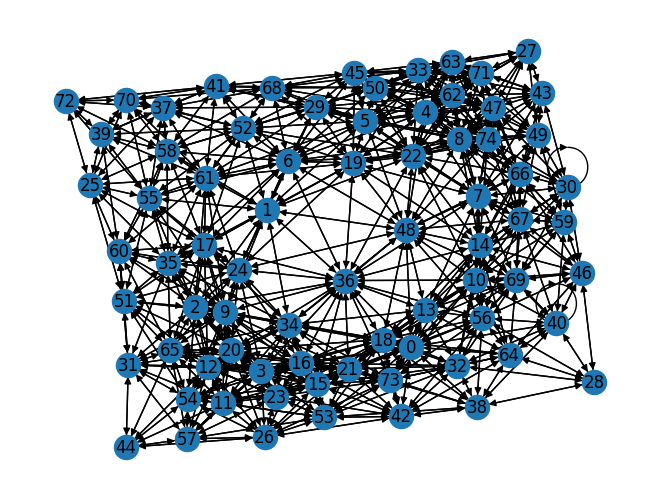

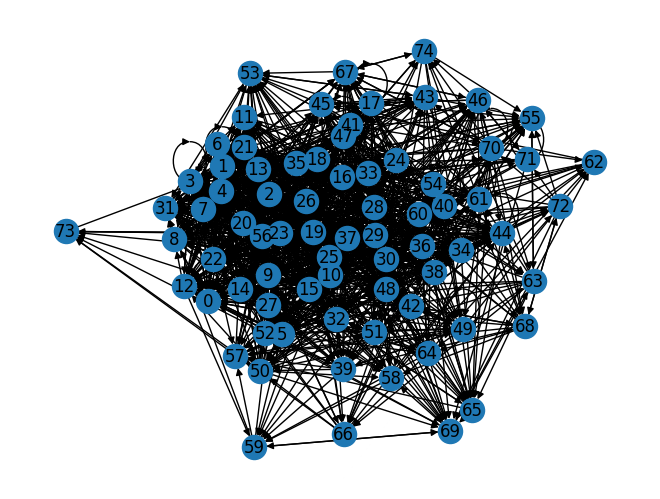

In [323]:
graph_real = to_networkx(gmixup_mnist.base_dataset[gmixup_mnist.graphs_by_class[0][0]])
graph_gen = gmixup_mnist.generate_graphs(0, 0, 0, K=75)

import matplotlib.pyplot as plt
print(graph_real)
print("graph real average degree: ", np.mean(list(dict(graph_real.degree()).values())))
print("Drawing Real Label 0 graph...")
plt.figure(1)
nx.draw(graph_real, with_labels=True)
plt.figure(2)
print(graph_gen)
print("graph gen average degree: ", np.mean(list(dict(graph_gen.degree()).values())))
print("Drawing Generated Label 0 graph...")
nx.draw(graph_gen, with_labels=True)